### load the data 

In [1]:
import csv 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
inputs = []
outputs = []

with open('acs_data2.csv', 'r') as f:

    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    
    for row in csv_reader:
    
        if line_count <= 1: 
            #ignore headers 
            input_labels = row[1:13]
            output_labels = row[-7:]
            line_count+=1 
            continue 
        
        in1 = [float(i) for i in row[1:13]]
        out1 = [float(i) for i in row[-7:]]
        
        inputs.append(in1)
        outputs.append(out1)
        
        line_count+= 1
        
xdat = np.array(inputs)
ydat = np.array(outputs)


### Understanding the input data

#### Visualizing the inputs (without sorting)

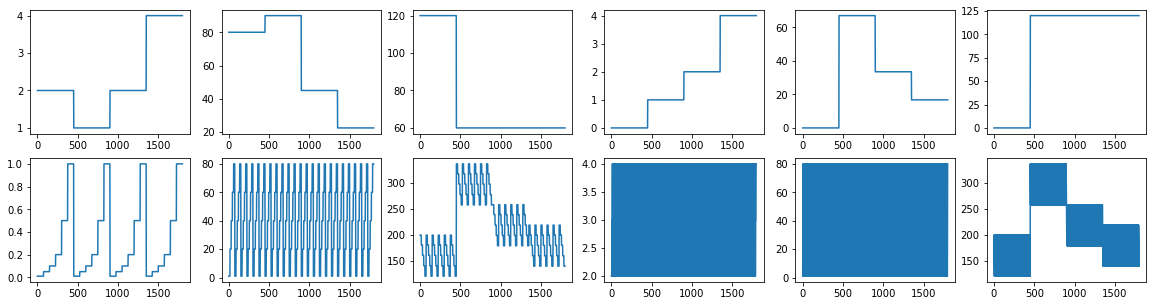

In [3]:
#visualizing the inputs

plt.figure(figsize = (20,5))
    
for i in range(12):
    plt.subplot(2,6,i+1)
    temp_variable = xdat[:,i]
    plt.plot(temp_variable)
    

#### Visualizing the inputs (after sorting)

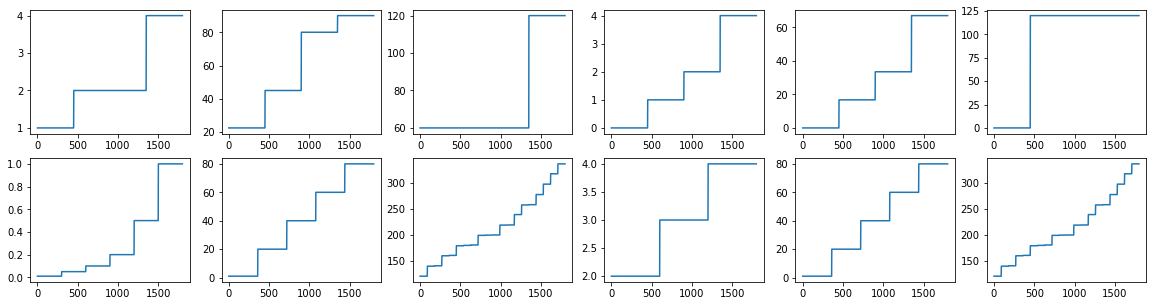

In [4]:
#visualizing the inputs
plt.figure(figsize = (20,5))
    
for i in range(12):
    plt.subplot(2,6,i+1)
    temp_variable = xdat[:,i].copy()
    temp_variable.sort()
    plt.plot(temp_variable)
    

In [14]:
#looking at the number of classes in each variable

num_cases = 1
classes =  []

for i in range(12):

    num_classes = len(set(xdat[:,i]))
    classes.append(num_classes)
    print(f"Number of classes in the variable {i+1} is {num_classes}")
    num_cases = num_cases*num_classes

print('Number of possible cases from all of these classes: ', num_cases )

Number of classes in the variable 1 is 3
Number of classes in the variable 2 is 4
Number of classes in the variable 3 is 2
Number of classes in the variable 4 is 4
Number of classes in the variable 5 is 4
Number of classes in the variable 6 is 2
Number of classes in the variable 7 is 6
Number of classes in the variable 8 is 5
Number of classes in the variable 9 is 20
Number of classes in the variable 10 is 3
Number of classes in the variable 11 is 5
Number of classes in the variable 12 is 20
Number of possible cases from all of these classes:  138240000


### Using random forests to learn the cure cycle model

In [31]:
#using random forests 
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.optimize import dual_annealing
from importlib import reload 

import acs_utils
acs_utils = reload(acs_utils)
from acs_utils import plot_inputs, plot_outputs, push_to_discrete


In [35]:
#normalize the inputs and outputs 

minmax_x = preprocessing.MinMaxScaler()
xdatn = minmax_x.fit_transform(xdat)
xdatdn  = minmax_x.inverse_transform(xdatn)

minmax_y = preprocessing.MinMaxScaler()
ydatn = minmax_y.fit_transform(ydat)
ydatdn  = minmax_y.inverse_transform(ydatn)

y_minimas, y_maximas = minmax_y.data_min_, minmax_y.data_max_

x_train, x_test, y_train, y_test = train_test_split(xdatn, ydatn, test_size=0.15, random_state=42)

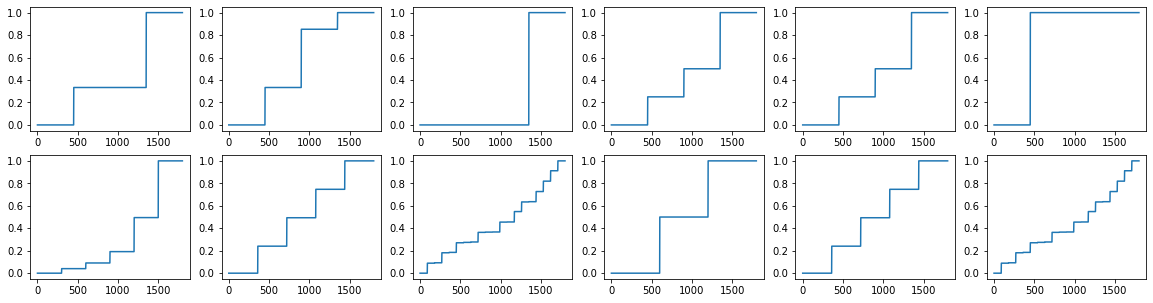

In [22]:
#visualizing the inputs
plt.figure(figsize = (20,5))

unique_vals_after_norm = []

for i in range(12):
    plt.subplot(2,6,i+1)
    temp_variable = xdatn[:,i].copy()
    temp_variable.sort()
    plt.plot(temp_variable)
    unique_vals_after_norm.append(np.unique(temp_variable))
    

In [23]:
#the unique values which the input space spans
unique_vals_after_norm

[array([0.        , 0.33333333, 1.        ]),
 array([0.        , 0.33333333, 0.85185185, 1.        ]),
 array([0., 1.]),
 array([0.  , 0.25, 0.5 , 1.  ]),
 array([0.  , 0.25, 0.5 , 1.  ]),
 array([0., 1.]),
 array([0.        , 0.04040404, 0.09090909, 0.19191919, 0.49494949,
        1.        ]),
 array([0.        , 0.24050633, 0.49367089, 0.74683544, 1.        ]),
 array([0.        , 0.08912037, 0.09259259, 0.18171296, 0.18518519,
        0.27083333, 0.27430556, 0.27777778, 0.36342593, 0.36574074,
        0.36689815, 0.45486111, 0.45601852, 0.54861111, 0.63425926,
        0.63657407, 0.72685185, 0.81944444, 0.91203704, 1.        ]),
 array([0. , 0.5, 1. ]),
 array([0.        , 0.24050633, 0.49367089, 0.74683544, 1.        ]),
 array([0.        , 0.08912037, 0.09259259, 0.18171296, 0.18518519,
        0.27083333, 0.27430556, 0.27777778, 0.36342593, 0.36574074,
        0.36689815, 0.45486111, 0.45601852, 0.54861111, 0.63425926,
        0.63657407, 0.72685185, 0.81944444, 0.91203704, 1. 

### Case-1: learning the (x1, ..x13) --> (y1, ..y7) (full map)

In [27]:
#train the model 

reg = RandomForestRegressor(random_state=0)
multi_output_reg_case_1 = MultiOutputRegressor(reg).fit(x_train, y_train)

print('Testing score: ', multi_output_reg_case_1.score(x_test, y_test)*100, '%')
print('Training score: ', multi_output_reg_case_1.score(x_train, y_train)*100, '%')


def loss_for_case_1(inp):
    '''
    Loss function for case -1: optimizing all outputs.
    '''
    discrete_input = push_to_discrete(inp, unique_vals_after_norm)
    denorm_input = minmax_x.inverse_transform([discrete_input])[0]

    
    ti = denorm_input[:6]
    vi = denorm_input[6:9]
    ai = denorm_input[9:12]

    time1 = ti[1]+ti[2]+ti[4]+ti[5]
    time2 = vi[1]+vi[2]
    time3 = ai[1]+ai[2]
    
    cs1 = abs(time1-time2)
    cs2 = abs(time2-time3)
    cs3 = abs(time3-time1)
    
    
    eps = 3
    
    if cs1 > eps or cs2 > eps or cs3 > eps:
        return np.inf
    
    
    forest_output = multi_output_reg_case_1.predict(np.array([inp]))

    y1, y2, y3, y4, y5, y6, y7 = forest_output[0]

    out  = y1**2 + y2**2 + y3**2 + (1-y4)**2 + y5**2 + y7**2
    
    return out 


#define optimization and solve it 

a0  = np.random.random([12,])

ndim = 12
bounds  = [[0,1] for i in range(ndim)]
dual_match_case_1 =dual_annealing(loss_for_case_1, x0=a0, bounds=bounds, maxiter = 1000)

print(dual_match_case_1)



Testing score:  98.7096066607998 %
Training score:  99.76687475622228 %


C:\Users\Kommalapati sahil\anaconda3\envs\ml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Kommalapati sahil\anaconda3\envs\ml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Kommalapati sahil\anaconda3\envs\ml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Kommalapati sahil\anaconda3\envs\ml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Kommalapati sahil\anaconda3\envs\ml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Kommalapati sahil\anaconda3\envs\ml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(

     fun: 0.32320563002094704
 message: ['Maximum number of iteration reached']
    nfev: 24698
    nhev: 0
     nit: 1000
    njev: 34
  status: 0
 success: True
       x: array([0.36106907, 0.02445769, 0.73562585, 0.54387136, 0.56905515,
       0.85674504, 0.01579235, 0.43565909, 0.59152342, 0.44735799,
       0.41988319, 0.59239717])


<Figure size 1080x360 with 0 Axes>

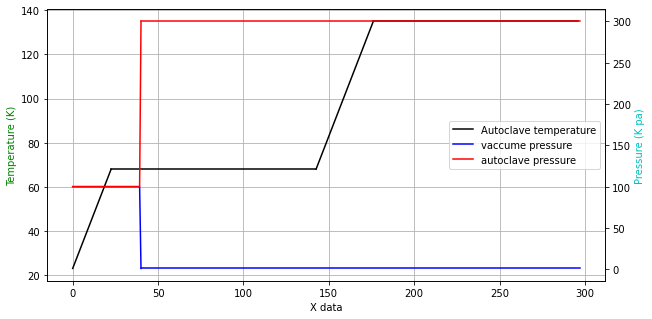

t1-296.0, t2-297.0, t3-297.0


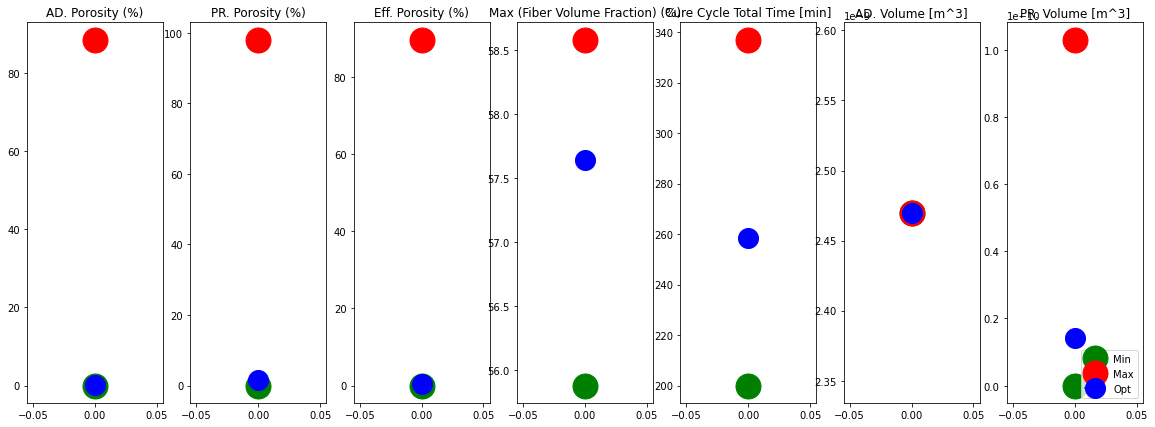

1

In [36]:

#plot the optimal cure cycle 

case_1_sol  = dual_match_case_1.x
sol_discrete = push_to_discrete(case_1_sol, unique_vals_after_norm)
sol_discrete_denorm = minmax_x.inverse_transform([sol_discrete])
sol = sol_discrete_denorm[0]

ti = sol[:6]
vi = sol[6:9]
ai = sol[9:12]

acs_utils.plot_inputs_v2(ti, vi, ai)

#plot the corresponding outputs 

y_output_case1 = multi_output_reg_case_1.predict([case_1_sol])
y_output_case1_denorm = minmax_y.inverse_transform(y_output_case1)
plot_outputs(y_output_case1_denorm[0,:], y_minimas, y_maximas, labels = output_labels)

### Case 2: learning (x1, .., x13) --> (y3, y4, y5)

Testing score:  99.99082584128928 %
Training score:  99.9991319226083 %
     fun: 0.001306506646978517
 message: ['Maximum number of iteration reached']
    nfev: 24657
    nhev: 0
     nit: 1000
    njev: 10
  status: 0
 success: True
       x: array([0.53567023, 0.65983477, 0.88332652, 0.04069321, 0.23194094,
       0.39793671, 0.00870583, 0.11537759, 0.41224027, 0.7801078 ,
       0.77990867, 0.13797037])


<Figure size 1080x360 with 0 Axes>

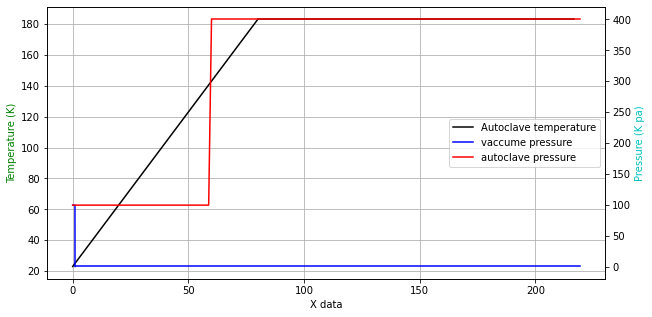

t1-216.75, t2-219.24999999999997, t3-219.25


1

In [47]:
y_train_case_2, y_test_case_2 = y_train[:,[2, 3, 4]], y_test[:, [2, 3, 4]]

reg_case_2 = RandomForestRegressor(random_state=0)
multi_output_reg_case_2 = MultiOutputRegressor(reg_case_2).fit(x_train, y_train_case_2)

print('Testing score: ', multi_output_reg_case_2.score(x_test, y_test_case_2)*100, '%')
print('Training score: ', multi_output_reg_case_2.score(x_train, y_train_case_2)*100, '%')



def loss_for_case_2(inp):
    '''
    Loss function for case -2: optimizing y3, y4, y5.
    '''
    
    discrete_input = push_to_discrete(inp, unique_vals_after_norm)
    denorm_input = minmax_x.inverse_transform([discrete_input])[0]

    
    ti = denorm_input[:6]
    vi = denorm_input[6:9]
    ai = denorm_input[9:12]

    time1 = ti[1]+ti[2]+ti[4]+ti[5]
    time2 = vi[1]+vi[2]
    time3 = ai[1]+ai[2]
    
    cs1 = abs(time1-time2)
    cs2 = abs(time2-time3)
    cs3 = abs(time3-time1)
    
    
    eps = 3
    
    if cs1 > eps or cs2 > eps or cs3 > eps:
        return np.inf
    
    
    forest_output = multi_output_reg_case_2.predict(np.array([inp]))

    y3, y4, y5 = forest_output[0]

    out  = y3**2 + (1-y4)**2 + y5**2
    
    return out 



#define optimization and solve it

a0  = np.random.random([12,])

ndim = 12
bounds  = [[0,1] for i in range(ndim)]
dual_match_case_2 =dual_annealing(loss_for_case_2, x0=a0, bounds=bounds, maxiter = 1000)

print(dual_match_case_2)


#plot cure cycle

case_2_sol  = dual_match_case_2.x
sol_discrete = push_to_discrete(case_2_sol, unique_vals_after_norm)
sol_discrete_denorm = minmax_x.inverse_transform([sol_discrete])
sol = sol_discrete_denorm[0]

ti = sol[:6]
vi = sol[6:9]
ai = sol[9:12]

acs_utils.plot_inputs_v2(ti, vi, ai)

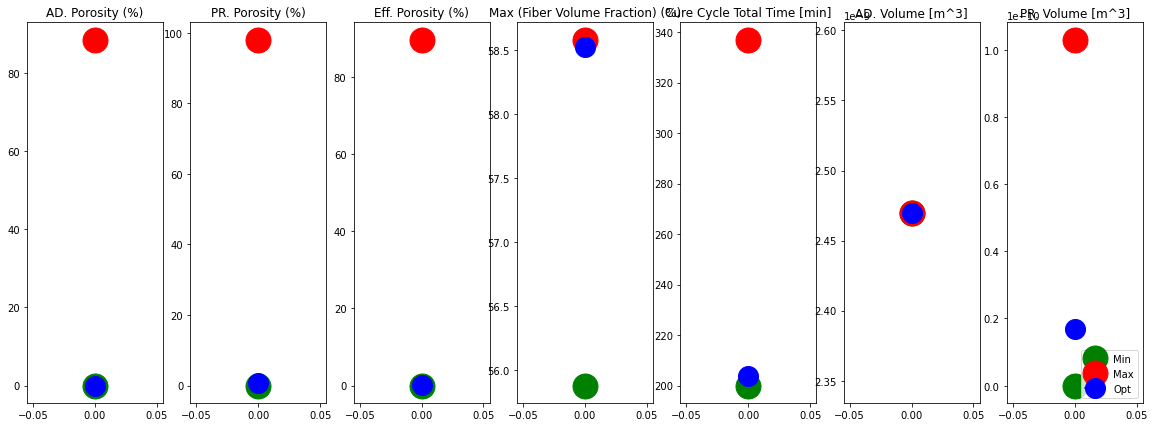

1

In [70]:
#plot outputs 
y_output_case2 = multi_output_reg_case_1.predict([case_2_sol])
y_output_case2_denorm = minmax_y.inverse_transform(y_output_case2)
plot_outputs(y_output_case2_denorm[0,:], y_minimas, y_maximas, labels = output_labels)

### Case 3: learning (x1, .., x13) --> (y3, y4)

Testing score:  99.98623876193392 %
Training score:  99.99869788391244 %
     fun: 0.0005170121044881519
 message: ['Maximum number of iteration reached']
    nfev: 24173
    nhev: 0
     nit: 1000
    njev: 9
  status: 0
 success: True
       x: array([0.71239409, 0.30727135, 0.33771459, 0.99004862, 0.52238741,
       0.76025978, 0.01852007, 0.56899715, 0.42886824, 0.96230747,
       0.35860081, 0.50706255])


<Figure size 1080x360 with 0 Axes>

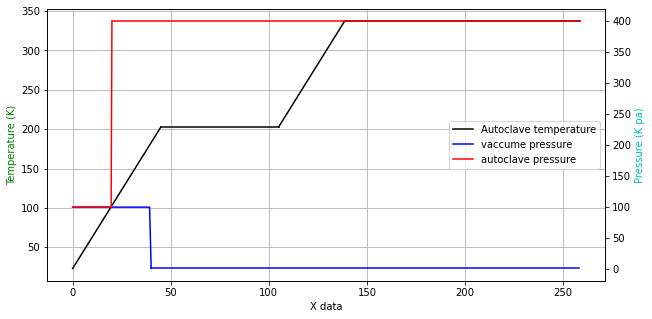

t1-258.5, t2-258.25, t3-258.5


1

In [46]:
y_train_case_3, y_test_case_3 = y_train[:,[2, 3]], y_test[:, [2, 3]]

reg_case_3 = RandomForestRegressor(random_state=0)
multi_output_reg_case_3 = MultiOutputRegressor(reg_case_3).fit(x_train, y_train_case_3)

print('Testing score: ', multi_output_reg_case_3.score(x_test, y_test_case_3)*100, '%')
print('Training score: ', multi_output_reg_case_3.score(x_train, y_train_case_3)*100, '%')



def loss_for_case_3(inp):
    
    '''
    Loss function for case -3: optimizing (y4, y3).
    '''
    discrete_input = push_to_discrete(inp, unique_vals_after_norm)
    denorm_input = minmax_x.inverse_transform([discrete_input])[0]

    ti = denorm_input[:6]
    vi = denorm_input[6:9]
    ai = denorm_input[9:12]

    time1 = ti[1]+ti[2]+ti[4]+ti[5]
    time2 = vi[1]+vi[2]
    time3 = ai[1]+ai[2]
    
    cs1 = abs(time1-time2)
    cs2 = abs(time2-time3)
    cs3 = abs(time3-time1)
    
    eps = 3
    
    if cs1 > eps or cs2 > eps or cs3 > eps:
        return np.inf
    
    
    forest_output = multi_output_reg_case_3.predict(np.array([inp]))

    y3, y4 = forest_output[0]

    out  = y3**2 + (1-y4)**2 
    
    return out 



#define optimization 

a0  = np.random.random([12,])

ndim = 12
bounds  = [[0,1] for i in range(ndim)]
dual_match_case_3 =dual_annealing(loss_for_case_3, x0=a0, bounds=bounds, maxiter = 1000)

print(dual_match_case_3)


#plot cure cycle 

case_3_sol  = dual_match_case_3.x
sol_discrete = push_to_discrete(case_3_sol, unique_vals_after_norm)
sol_discrete_denorm = minmax_x.inverse_transform([sol_discrete])
sol = sol_discrete_denorm[0]

ti = sol[:6]
vi = sol[6:9]
ai = sol[9:12]

acs_utils.plot_inputs_v2(ti, vi, ai)

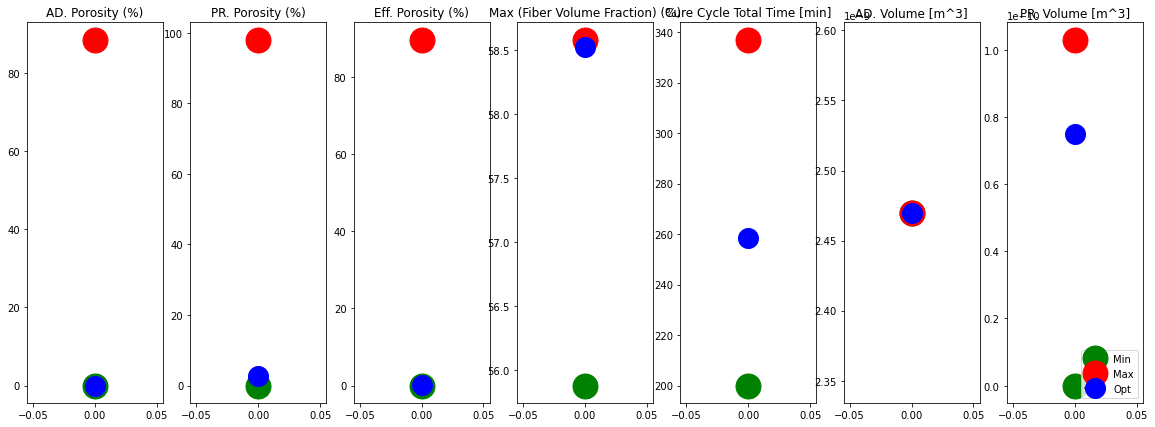

1

In [71]:
#plot outputs 
y_output_case3 = multi_output_reg_case_1.predict([case_3_sol])
y_output_case3_denorm = minmax_y.inverse_transform(y_output_case3)
plot_outputs(y_output_case3_denorm[0,:], y_minimas, y_maximas, labels = output_labels)

### Case 4: learning (x1, .., x13) --> (y4, y5)

Testing score:  99.99966097802167 %
Training score:  99.99995366296876 %
     fun: 0.001283944222761472
 message: ['Maximum number of iteration reached']
    nfev: 24363
    nhev: 0
     nit: 1000
    njev: 19
  status: 0
 success: True
       x: array([0.49710669, 0.81348606, 0.95664616, 0.05001738, 0.16220703,
       0.10435785, 0.00288949, 0.42320084, 0.22875704, 0.97719926,
       0.25944699, 0.38555544])


<Figure size 1080x360 with 0 Axes>

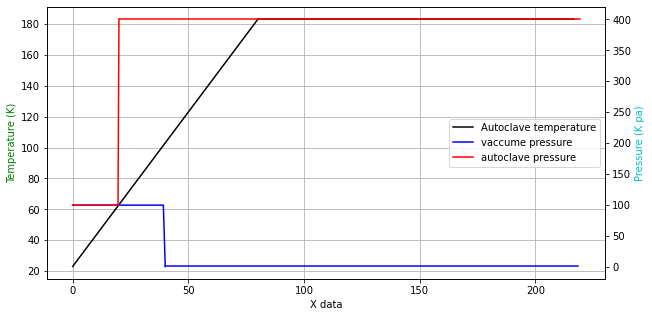

t1-216.75, t2-218.5, t3-219.25


1

In [45]:
y_train_case_4, y_test_case_4 = y_train[:,[3, 4]], y_test[:, [3, 4]]

reg_case_4 = RandomForestRegressor(random_state=0)
multi_output_reg_case_4 = MultiOutputRegressor(reg_case_4).fit(x_train, y_train_case_4)

print('Testing score: ', multi_output_reg_case_4.score(x_test, y_test_case_4)*100, '%')
print('Training score: ', multi_output_reg_case_4.score(x_train, y_train_case_4)*100, '%')



def loss_for_case_4(inp):
    '''
    Loss function for case -4: optimizing (y4, y5). 
    '''
    
    discrete_input = push_to_discrete(inp, unique_vals_after_norm)
    denorm_input = minmax_x.inverse_transform([discrete_input])[0]
    
    ti = denorm_input[:6]
    vi = denorm_input[6:9]
    ai = denorm_input[9:12]

    time1 = ti[1]+ti[2]+ti[4]+ti[5]
    time2 = vi[1]+vi[2]
    time3 = ai[1]+ai[2]
    
    cs1 = abs(time1-time2)
    cs2 = abs(time2-time3)
    cs3 = abs(time3-time1)
    
    eps = 3
    
    if cs1 > eps or cs2 > eps or cs3 > eps:
        return np.inf
    
    
    forest_output = multi_output_reg_case_4.predict(np.array([inp]))

    y4, y5 = forest_output[0]

    out  = y5**2 + (1-y4)**2 
    
    return out 



#define optimization and solve it 

a0  = np.random.random([12,])
ndim = 12
bounds  = [[0,1] for i in range(ndim)]
dual_match_case_4 =dual_annealing(loss_for_case_4, x0=a0, bounds=bounds, maxiter = 1000)

print(dual_match_case_4)


#plot cure cycle

case_4_sol  = dual_match_case_4.x
sol_discrete = push_to_discrete(case_4_sol, unique_vals_after_norm)
sol_discrete_denorm = minmax_x.inverse_transform([sol_discrete])
sol = sol_discrete_denorm[0]

ti = sol[:6]
vi = sol[6:9]
ai = sol[9:12]

acs_utils.plot_inputs_v2(ti, vi, ai)

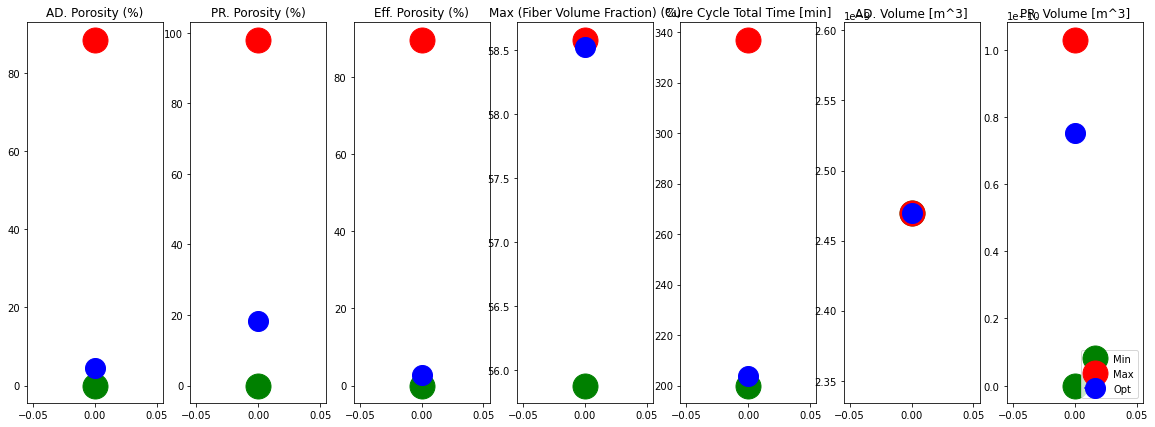

1

In [72]:
#plot outputs 
y_output_case4 = multi_output_reg_case_1.predict([case_4_sol])
y_output_case4_denorm = minmax_y.inverse_transform(y_output_case4)
plot_outputs(y_output_case4_denorm[0,:], y_minimas, y_maximas, labels = output_labels)

### Case 5: learning (x1, .., x13) --> (y1, y2)

Testing score:  96.83428008699804 %
Training score:  99.37956986858563 %
     fun: 4.807463343015056e-06
 message: ['Maximum number of iteration reached']
    nfev: 24552
    nhev: 0
     nit: 1000
    njev: 25
  status: 0
 success: True
       x: array([0.36470251, 0.48099876, 0.85207889, 0.62701353, 0.45644366,
       0.74888592, 0.00730279, 0.40902352, 0.70728493, 0.26136541,
       0.17151454, 0.85464192])


<Figure size 1080x360 with 0 Axes>

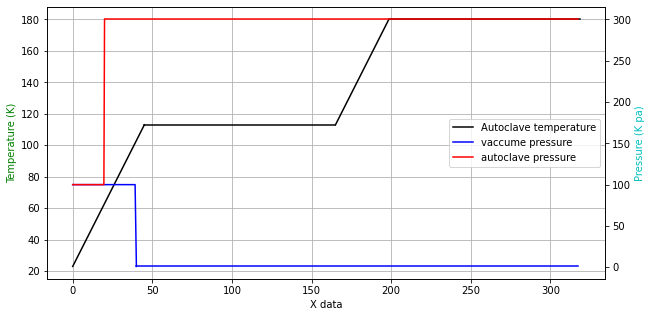

t1-318.5, t2-317.0, t3-317.0


1

In [44]:
y_train_case_5, y_test_case_5 = y_train[:,[0, 1]], y_test[:, [0, 1]]

reg_case_5 = RandomForestRegressor(random_state=0)
multi_output_reg_case_5 = MultiOutputRegressor(reg_case_5).fit(x_train, y_train_case_5)

print('Testing score: ', multi_output_reg_case_5.score(x_test, y_test_case_5)*100, '%')
print('Training score: ', multi_output_reg_case_5.score(x_train, y_train_case_5)*100, '%')



def loss_for_case_5(inp):
    
    '''
    Loss function for case -5: optimizing (y1, y2). 
    '''
    
    discrete_input = push_to_discrete(inp, unique_vals_after_norm)
    denorm_input = minmax_x.inverse_transform([discrete_input])[0]

    ti = denorm_input[:6]
    vi = denorm_input[6:9]
    ai = denorm_input[9:12]

    time1 = ti[1]+ti[2]+ti[4]+ti[5]
    time2 = vi[1]+vi[2]
    time3 = ai[1]+ai[2]
    
    cs1 = abs(time1-time2)
    cs2 = abs(time2-time3)
    cs3 = abs(time3-time1)
    
    eps = 3
    
    if cs1 > eps or cs2 > eps or cs3 > eps:
        return np.inf
    
    
    forest_output = multi_output_reg_case_5.predict(np.array([inp]))

    y1, y2 = forest_output[0]

    out  = y1**2 + y2**2 
    
    return out 



#define optimization and solve it

a0  = np.random.random([12,])

ndim = 12
bounds  = [[0,1] for i in range(ndim)]
dual_match_case_5 =dual_annealing(loss_for_case_5, x0=a0, bounds=bounds, maxiter = 1000)
print(dual_match_case_5)


#solution from the optimization and plot cure cycle


case_5_sol  = dual_match_case_5.x
sol_discrete = push_to_discrete(case_5_sol, unique_vals_after_norm)
sol_discrete_denorm = minmax_x.inverse_transform([sol_discrete])
sol = sol_discrete_denorm[0]

ti = sol[:6]
vi = sol[6:9]
ai = sol[9:12]

acs_utils.plot_inputs_v2(ti, vi, ai)

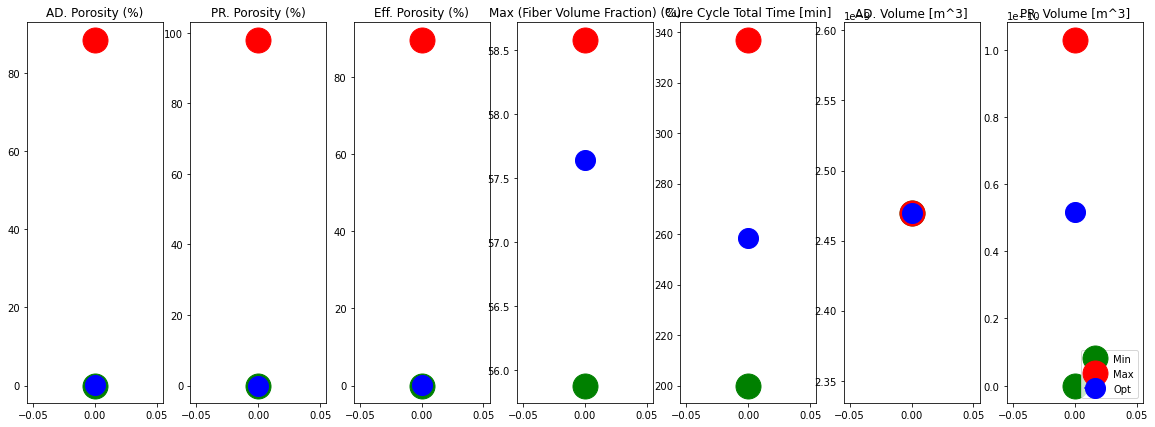

1

In [73]:
#plot outputs 
y_output_case5 = multi_output_reg_case_1.predict([case_5_sol])
y_output_case5_denorm = minmax_y.inverse_transform(y_output_case5)
plot_outputs(y_output_case5_denorm[0,:], y_minimas, y_maximas, labels = output_labels)

### Case 6: learning (x1, .., x13) --> (y3, y4, y7)

Testing score:  99.0995621505342 %
Training score:  99.8696611854616 %
     fun: 0.0005111806577397614
 message: ['Maximum number of iteration reached']
    nfev: 24313
    nhev: 0
     nit: 1000
    njev: 15
  status: 0
 success: True
       x: array([4.93544957e-01, 4.94145121e-01, 3.50336443e-02, 6.71839651e-01,
       1.62764950e-01, 5.24399404e-01, 6.73248732e-04, 5.37113923e-01,
       3.65218058e-01, 8.35399928e-01, 8.56333733e-01, 2.50078148e-01])


<Figure size 1080x360 with 0 Axes>

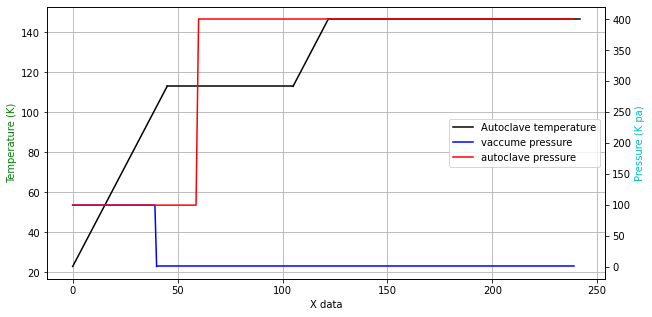

t1-241.75, t2-239.0, t3-238.5


1

In [59]:
y_train_case_6, y_test_case_6 = y_train[:,[2, 3, 6]], y_test[:, [2, 3, 6]]

reg_case_6 = RandomForestRegressor(random_state=0)
multi_output_reg_case_6 = MultiOutputRegressor(reg_case_6).fit(x_train, y_train_case_6)

print('Testing score: ', multi_output_reg_case_6.score(x_test, y_test_case_6)*100, '%')
print('Training score: ', multi_output_reg_case_6.score(x_train, y_train_case_6)*100, '%')



def loss_for_case_6(inp):
    '''
    Loss function for case -6: optimizing (y3, y4, y7). 
    '''
    discrete_input = push_to_discrete(inp, unique_vals_after_norm)
    denorm_input = minmax_x.inverse_transform([discrete_input])[0]

    ti = denorm_input[:6]
    vi = denorm_input[6:9]
    ai = denorm_input[9:12]

    time1 = ti[1]+ti[2]+ti[4]+ti[5]
    time2 = vi[1]+vi[2]
    time3 = ai[1]+ai[2]
    
    cs1 = abs(time1-time2)
    cs2 = abs(time2-time3)
    cs3 = abs(time3-time1)
    
    
    eps = 5
    
    if cs1 > eps or cs2 > eps or cs3 > eps:
        return np.inf
    
    
    forest_output = multi_output_reg_case_6.predict(np.array([inp]))

    y3, y4, y7 = forest_output[0]

    out  = y3**2 + (1-y4)**2 + y7**2 
    
    return out 



#define optimization and solve it 

a0  = np.random.random([12,])

ndim = 12
bounds  = [[0,1] for i in range(ndim)]
dual_match_case_6 =dual_annealing(loss_for_case_6, x0=a0, bounds=bounds, maxiter = 1000)
print(dual_match_case_6)


#solution from the optimization and plot cure cycle 


case_6_sol  = dual_match_case_6.x
sol_discrete = push_to_discrete(case_6_sol, unique_vals_after_norm)
sol_discrete_denorm = minmax_x.inverse_transform([sol_discrete])
sol = sol_discrete_denorm[0]

ti = sol[:6]
vi = sol[6:9]
ai = sol[9:12]

acs_utils.plot_inputs_v2(ti, vi, ai)

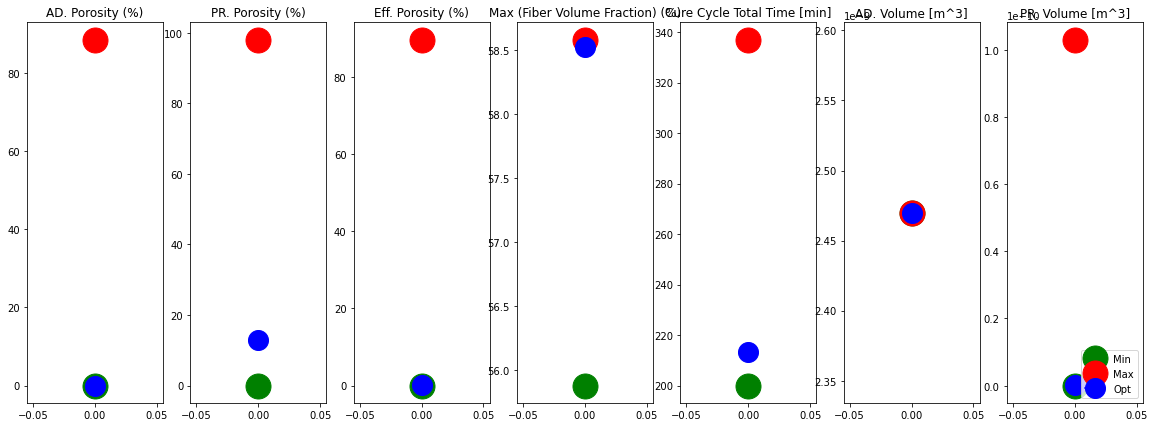

1

In [74]:
#plot outputs 
y_output_case6 = multi_output_reg_case_1.predict([case_6_sol])
y_output_case6_denorm = minmax_y.inverse_transform(y_output_case6)
plot_outputs(y_output_case6_denorm[0,:], y_minimas, y_maximas, labels = output_labels)

### Case 7: (x1, x2, .. x12) --> (y1, y2, y3, ..y6)

Testing score:  98.94017294964398 %
Training score:  99.79275591749935 %
     fun: 0.003819948333662469
 message: ['Maximum number of iteration reached']
    nfev: 24436
    nhev: 0
     nit: 1000
    njev: 28
  status: 0
 success: True
       x: array([0.65000358, 0.63461487, 0.94562384, 0.39879708, 0.08039296,
       0.78762715, 0.00364847, 0.88820873, 0.5852914 , 0.94008277,
       0.74457366, 0.68154262])


<Figure size 1080x360 with 0 Axes>

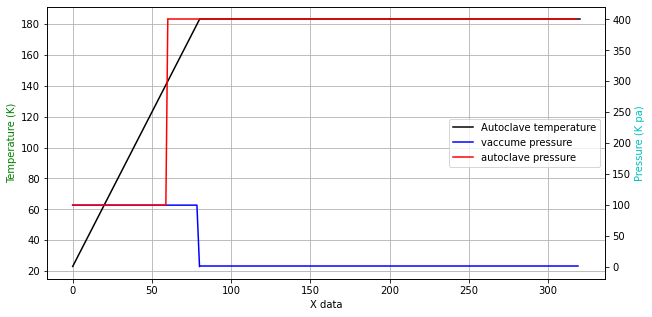

t1-320.0, t2-318.5, t3-317.5


1

In [91]:
y_train_case_7, y_test_case_7 = y_train[:,:6], y_test[:, :6]
reg_case_7 = RandomForestRegressor(random_state=0)
multi_output_reg_case_7 = MultiOutputRegressor(reg_case_7).fit(x_train, y_train_case_7)

print('Testing score: ', multi_output_reg_case_7.score(x_test, y_test_case_7)*100, '%')
print('Training score: ', multi_output_reg_case_7.score(x_train, y_train_case_7)*100, '%')



def loss_for_case_7(inp):
    
    '''
    Loss function for case -7: optimizing (y3, y4, y7). 
    '''
    
    reg_factor = 1
    
    discrete_input = push_to_discrete(inp, unique_vals_after_norm)
    denorm_input = minmax_x.inverse_transform([discrete_input])[0]

    ti = denorm_input[:6]
    vi = denorm_input[6:9]
    ai = denorm_input[9:12]

    time1 = ti[1]+ti[2]+ti[4]+ti[5]
    time2 = vi[1]+vi[2]
    time3 = ai[1]+ai[2]
    
    cs1 = abs(time1-time2)
    cs2 = abs(time2-time3)
    cs3 = abs(time3-time1)
    
    
    eps = 5
    
    if cs1 > eps or cs2 > eps or cs3 > eps:
        return np.inf
    
    
    forest_output = multi_output_reg_case_7.predict(np.array([inp]))

    y1, y2, y3, y4, y5, y6 = forest_output[0]

    out  = y1**2 + y2**2 + y3**2 + (1-y4)**2 + y5**2 
    
    return out 



#define optimization and solve it 

a0  = np.random.random([12,])

ndim = 12
bounds  = [[0,1] for i in range(ndim)]
dual_match_case_7 =dual_annealing(loss_for_case_7, x0=a0, bounds=bounds, maxiter = 1000)
print(dual_match_case_7)


#solution from the optimization and plot cure cycle


case_7_sol  = dual_match_case_7.x
sol_discrete = push_to_discrete(case_7_sol, unique_vals_after_norm)
sol_discrete_denorm = minmax_x.inverse_transform([sol_discrete])
sol = sol_discrete_denorm[0]

ti = sol[:6]
vi = sol[6:9]
ai = sol[9:12]

acs_utils.plot_inputs_v2(ti, vi, ai)

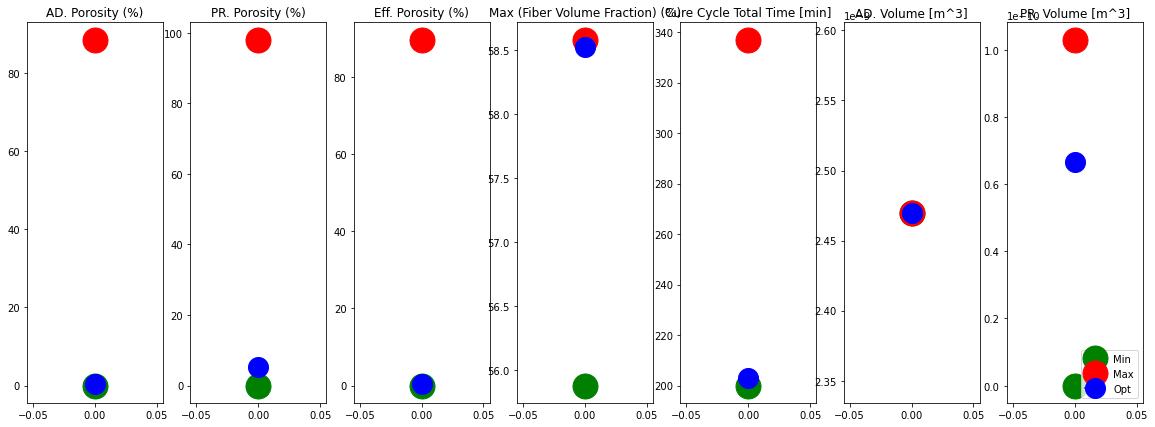

1

In [92]:
#plot outputs 
y_output_case7 = multi_output_reg_case_1.predict([case_7_sol])
y_output_case7_denorm = minmax_y.inverse_transform(y_output_case7)
plot_outputs(y_output_case7_denorm[0,:], y_minimas, y_maximas, labels = output_labels)